In [77]:
import os
import random
import seaborn as sns
import csv
import numpy as np
import copy
import matplotlib.pyplot as plt
import datetime
from datetime import datetime
import pandas as pd
from scipy import stats
import math
import scipy.special
%matplotlib inline

In [78]:
#ICI MODIFIER LA PATH DU REPOSITORY
file_path="C:/Users/Zeta/Documents/acou_sommeil_HD_ENS/tinnitus-nocturnal-stimulation"

In [79]:
df_matin={}
os.chdir(file_path+"/df_matin")
files = os.listdir(file_path+"/df_matin")
for file in files:
    df_matin[file.split("_")[0]]=pd.read_csv(file, sep=";")
print("exemple matin")
print(df_matin["1ZN04"])

print("")

df_soir={}
os.chdir(file_path+"/df_soir")
files = os.listdir(file_path+"/df_soir")
for file in files:
    df_soir[file.split("_")[0]]=pd.read_csv(file, sep=";")
print("exemple soir")
print(df_soir["1ZN04"])

exemple matin
   Patient ID  relative date  masking volume  VAS-L  VAS-I  \
0       1ZN04            -22        7.333333    2.0    1.0   
1       1ZN04            -21        5.000000    3.0    2.0   
2       1ZN04            -21        5.000000    3.0    2.0   
3       1ZN04            -20        5.666667    NaN    NaN   
4       1ZN04            -19        5.000000    4.0    3.0   
5       1ZN04            -18        4.666667    5.0    3.0   
6       1ZN04            -17        4.666667    3.0    2.0   
7       1ZN04            -16        4.666667    2.0    2.0   
8       1ZN04            -15        5.333333    3.0    3.0   
9       1ZN04             -3        4.000000    4.0    2.0   
10      1ZN04             -1        5.333333    3.0    2.0   
11      1ZN04              0        4.666667    3.0    2.0   
12      1ZN04              2        4.666667    3.0    1.0   
13      1ZN04              3        5.333333    3.0    2.0   
14      1ZN04              4        4.333333    3.0    2

# Fonctions de calcul des p-values et d'affichage

In [80]:
def test_randomisé_inferiorité(li_obs, val_test, itera):
#Test randomisé unilatéral inférieur de la probabilité d'un élément individuel d'appartenir à une distribution
# li_obs: list of floats : liste d'élément de la distribution
# val_test : float :  élément individuel à tester
# itera : int : nombre d'itérations de permutations à accomplir. Plus ce nombre est élevé plus on a de précision sur la p_value calculée 
# Return : float : pval: p_value du test randomisé
    obs_stat= np.sum(li_obs)
    compt=0
    for i in range(itera):
        to_exclude = int(random.random()*len(li_obs))
        li_obs2=copy.deepcopy(li_obs)
        li_obs2.pop(to_exclude)
        li_obs2.append(val_test)

        if np.sum(li_obs2)> obs_stat:
            compt+=1

    pval = float(compt/itera)
    return (pval)

def combine_p_values(vect_p):
# Fonction de combinaison de p_value de Fisher, permet de tester H0 l'hypothèse que les p_value sont uniformément réparties entre 0 et 1. 
# vect_p : list of floats: liste de p_values à tester
# Return : float : combined p_value : probabilité de validité de l'hypothèse H0.
    sump=0.0
    N = len(vect_p)
    for k in range(N):
        sump+=vect_p[k]
    lnfact=0.0
    for k in range(N-1):
        lnfact+= math.log(k+2)
    k=0
    num=0
    sw=1.0
    while (sump-k)>0 :
        num+= (scipy.special.binom(N, k)*((sump-k)**N))*sw
        k=k+1
        sw= - sw
    if num == 0 : 
        return 0
    else:
        res = math.exp(math.log(num)-lnfact)
    return res


def get_me_p_vals(df, column, THR_exclude=4):
# Calcule des séquences de p_valeursde la probabilité d'infériorité par rapport à la distribution de référence 
# pré passsage à l'hôpital, organisées en 1 dictionnaire trié par patient et une liste triée par jour suivant l'intervention
# df : dictionnaire de pandas dataframe des données à tester, chaque df doit contenir au moins une colonne "relative date"
# column : str, nom de la colonne à valeur numériques (float) dont on veut calculer les p_valeurs
# THR_exclude: nb de données minimal dans la distrib pre intervention, au moins 4 scores dans la distribution pre-intervention
# Returns : p_vals_par_patient (dictionnaire de listes), p_vals_par_jour(liste de liste)
    p_vals_par_patient={}
    p_vals_par_jour=[[] for i in range(15)] #15 HARDCODED: nombre de jours maximal post intervention où on peut s'attendre à avoir des données mesurées

    for elm in df:
        
        p_vals_par_patient[elm]=[]
        distrib_pre_intervention=[]
        #Creation de la distribution de référence
        for index, row in df[elm].iterrows():
            if row['relative date'] < -1: # journée 
                if not np.isnan(row[column]):
                    distrib_pre_intervention.append(row[column])
            # petite économie du parcours des df, pressupose que les df soient rangées suivant l'index de relative date
            if row['relative date'] >= -1:
                break
        # Remplissage organisé des listes de p_val
        for index, row in df[elm].iterrows():
            if len(distrib_pre_intervention)>=THR_exclude: 
                if row['relative date'] >= 0:
                    if not np.isnan(row[column]):
                        post_intervention = row[column]
                        p_val= test_randomisé_inferiorité(distrib_pre_intervention, post_intervention, 10000)
                        p_vals_par_patient[elm].append(p_val)
                        p_vals_par_jour[row['relative date']].append(p_val)
    print("computing done")
    return(p_vals_par_patient, p_vals_par_jour)
    

def affichage_results_group(p_vals_par_jour, THR_exclude=7): 
#Calcule puis affiche les résultats sur le groupe par combinaison des p_valeurs jour par jour après l'intervention
# THR_exclude : we only combine p_vals if there 7 or more patients included
    compt=0
    li_comb=[]
    for li in p_vals_par_jour:
        if len(li)>=THR_exclude:  
            print("Combined p_value for day "+ str(compt))
            comb= combine_p_values(li)
            print(comb)
            li_comb.append(comb)
        compt+=1

    print("affichage sequence combined p_values :")
    l=[0.05 for i in range(len(li_comb))]
    plt.figure()
    plt.plot(li_comb)
    plt.plot(l)
    plt.title("Group combined p_values sequence for post intervention days, orange line: 0.05 threshold")
    plt.xlabel("days after intervention")
    plt.ylabel("combined p_value")
    
def affichage_results_intra(p_vals_par_patient):
#Affiche patient par patient les p_values jour après jour après  l'intervention de la probabilité 
# d'infériorité par rapport à la distribution de référence pré passsage à l'hôpital
    for elm in p_vals_par_patient:
        l=[0.05 for i in range(len(p_vals_par_patient[elm]))]
        plt.figure()
        plt.plot(p_vals_par_patient[elm])
        plt.plot(l)
        plt.title(elm + " p_values sequence for post intervention days, orange line: 0.05 threshold")
        plt.xlabel("days after intervention")
        plt.ylabel("p_value")

# Computing all metrics

In [81]:
#Masquage matin
p_vals_par_patient_matin_mask, p_vals_par_jour_matin_mask = get_me_p_vals(df_matin, "masking volume")
#Masquage soir
p_vals_par_patient_soir_mask, p_vals_par_jour_soir_mask = get_me_p_vals(df_soir, "masking volume")
#VAS-L
p_vals_par_patient_matin_VAS_L, p_vals_par_jour_matin_VAS_L = get_me_p_vals(df_matin, "VAS-L")
#VAS-I
p_vals_par_patient_matin_VAS_I, p_vals_par_jour_matin_VAS_I = get_me_p_vals(df_matin, "VAS-I")

computing done
computing done
computing done
computing done


# Analyse intra-sujet matin masquage

Combined p_value for day 0
0.00029401728882279157
Combined p_value for day 1
0.018478198332469175
Combined p_value for day 2
0.10708065338480713
Combined p_value for day 3
0.724606514723838
Combined p_value for day 4
0.07354232263419194
Combined p_value for day 5
0.5078078052095483
Combined p_value for day 6
0.25585552410926155
affichage sequence combined p_values :


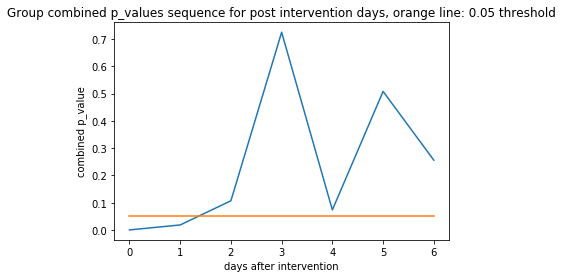

In [82]:
affichage_results_group(p_vals_par_jour_matin_mask)

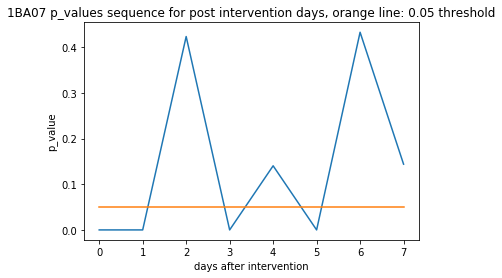

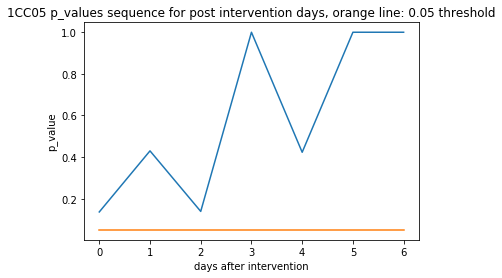

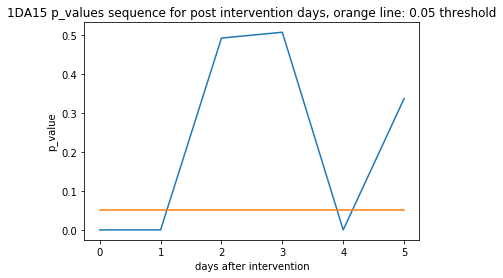

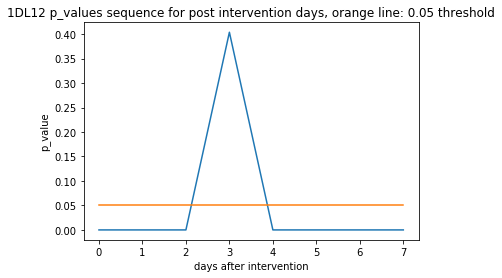

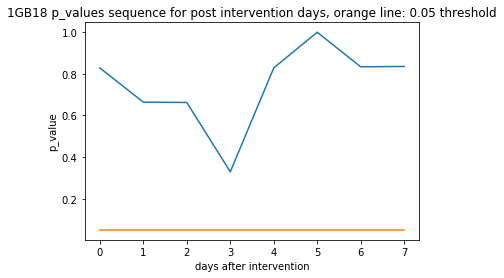

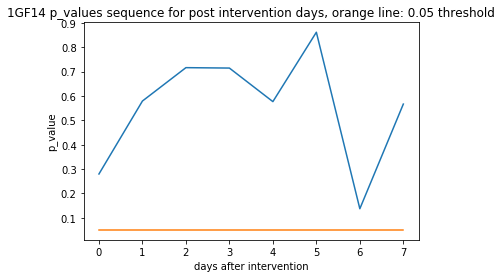

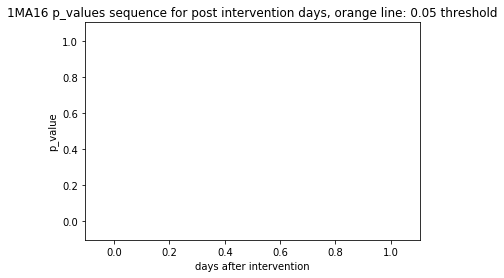

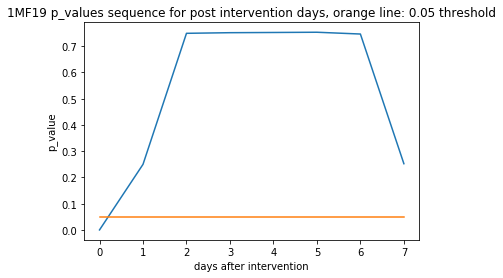

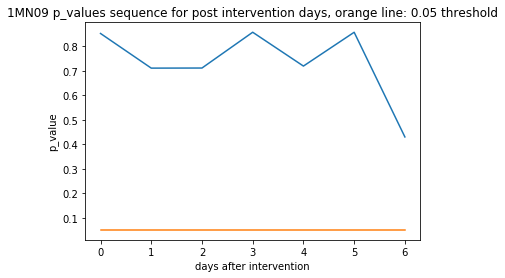

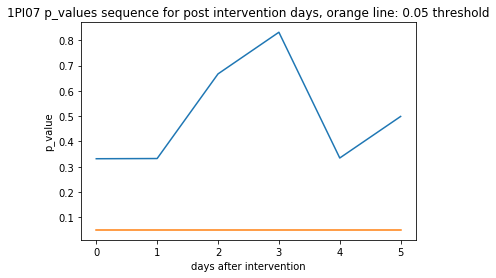

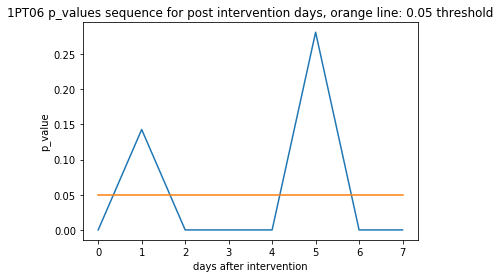

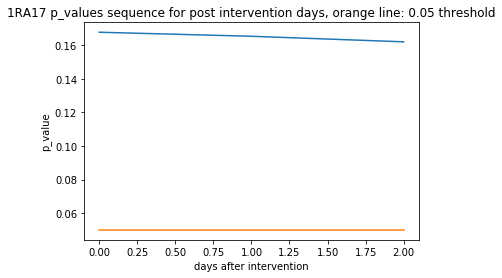

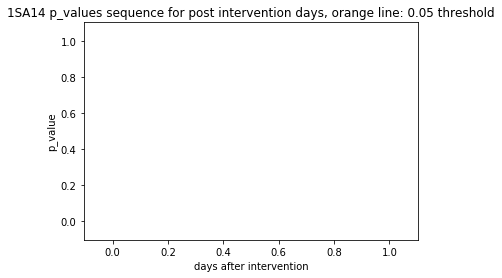

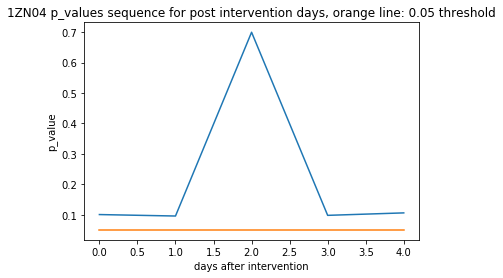

In [83]:
affichage_results_intra(p_vals_par_patient_matin_mask)

# Analyse intra-sujet soir masquage

Combined p_value for day 0
0.027169141652498365
Combined p_value for day 1
0.651186072526089
Combined p_value for day 2
0.39298406706963984
Combined p_value for day 3
0.39331633939561045
Combined p_value for day 4
0.28308990512176896
Combined p_value for day 5
0.4216982953730703
Combined p_value for day 6
0.2571460680549504
affichage sequence combined p_values :


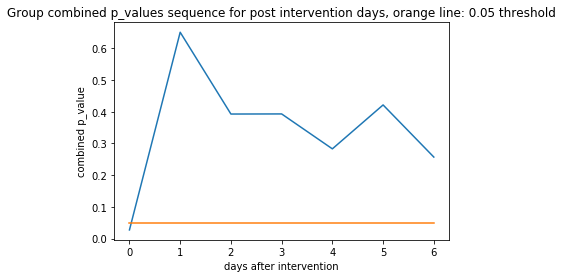

In [84]:
affichage_results_group(p_vals_par_jour_soir_mask)

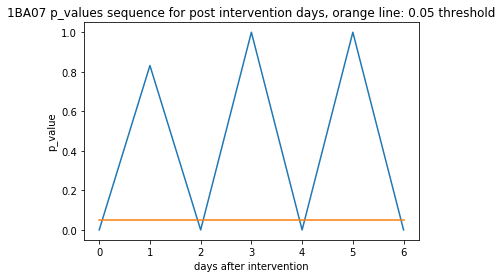

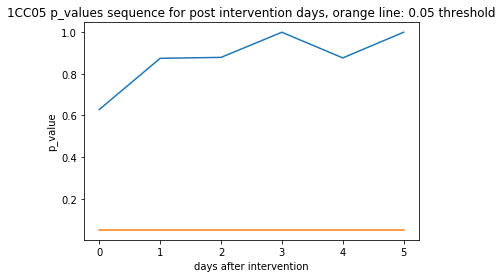

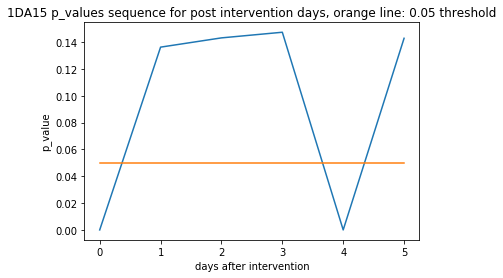

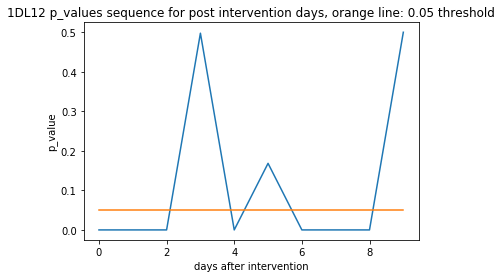

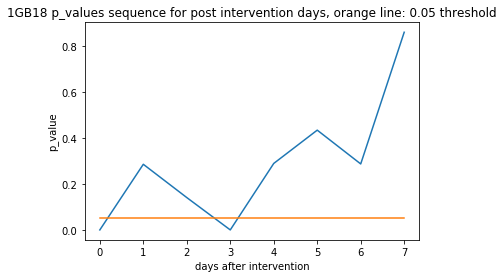

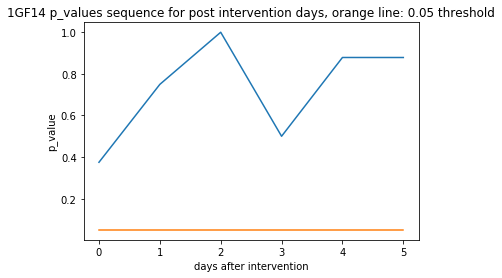

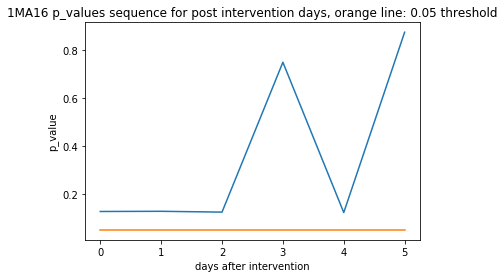

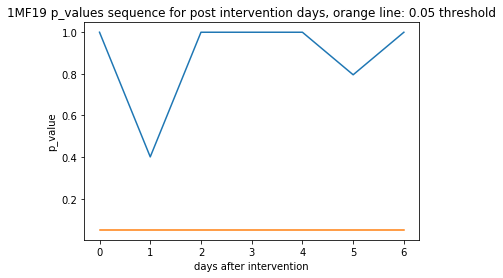

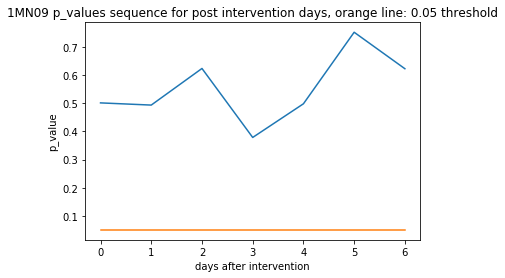

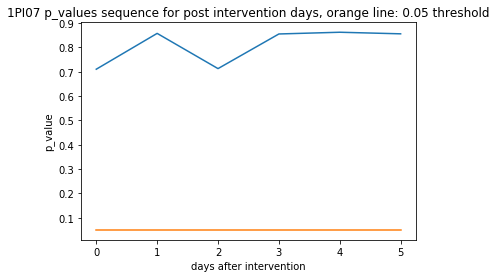

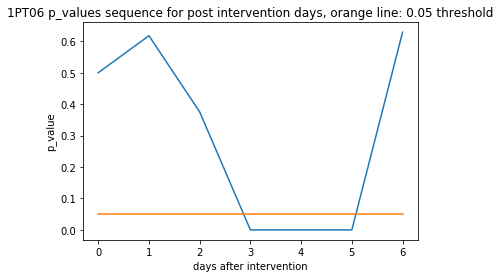

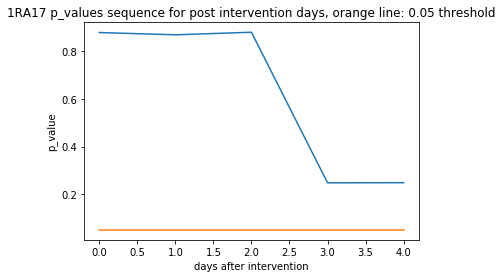

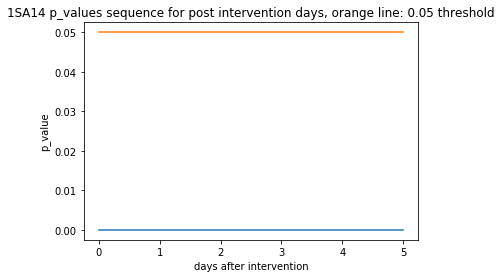

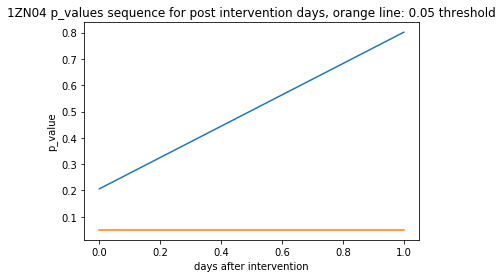

In [85]:
affichage_results_intra(p_vals_par_patient_soir_mask)

# Analyse intra-sujet matin VAS-L

Combined p_value for day 0
7.413277624532896e-07
Combined p_value for day 1
0.0026395041508587
Combined p_value for day 2
0.3040789424906994
Combined p_value for day 3
0.11526803445275387
Combined p_value for day 4
0.052281554710522316
Combined p_value for day 5
0.23867971900759508
Combined p_value for day 6
0.15278875757204943
affichage sequence combined p_values :


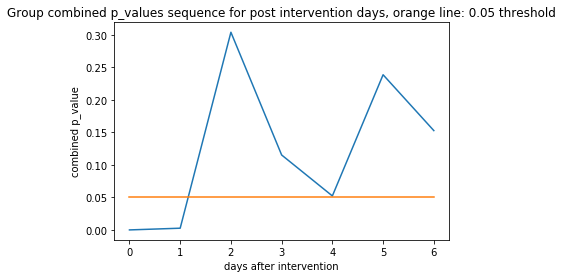

In [86]:
affichage_results_group(p_vals_par_jour_matin_VAS_L)

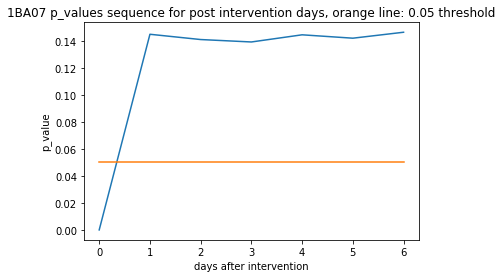

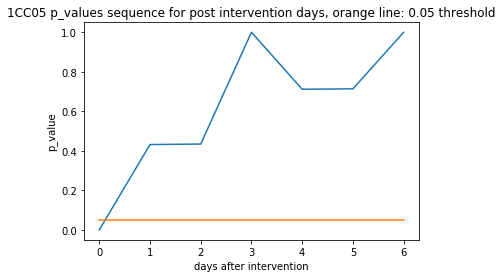

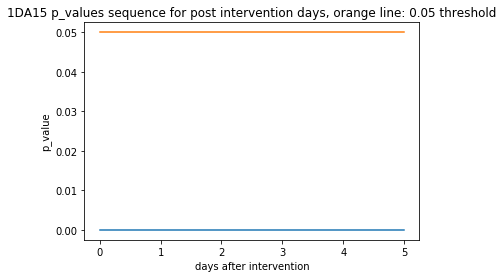

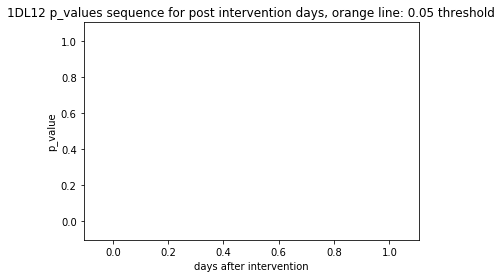

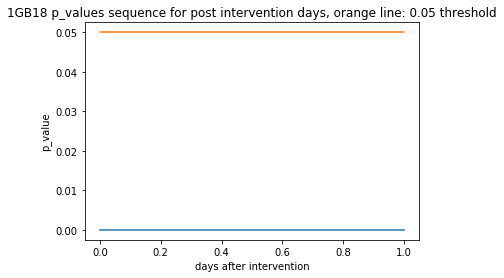

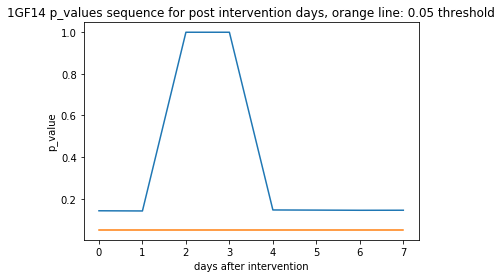

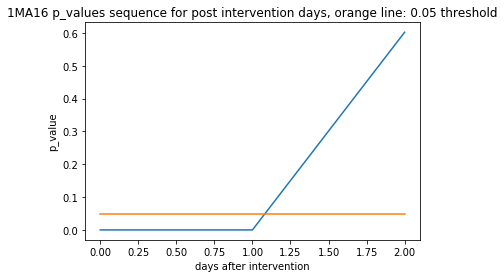

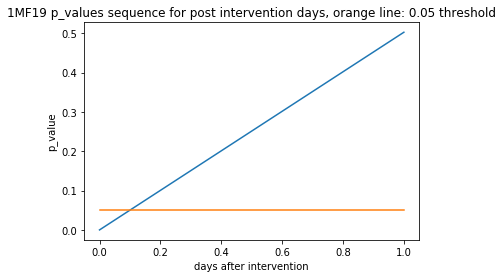

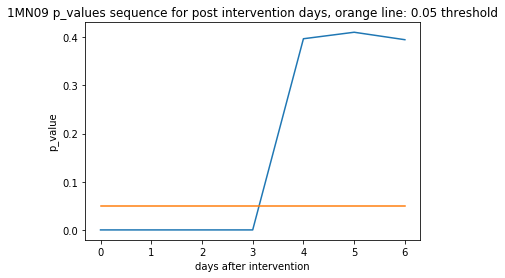

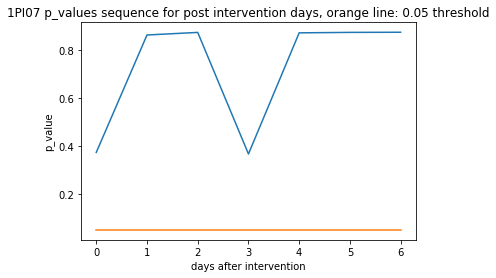

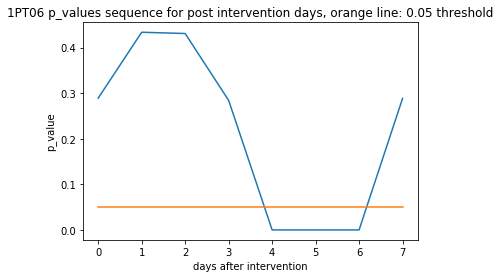

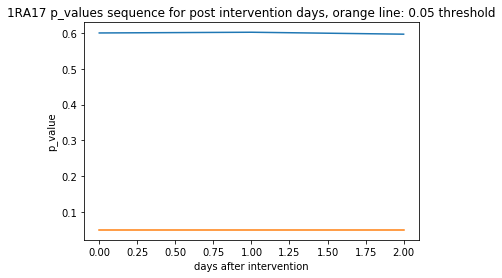

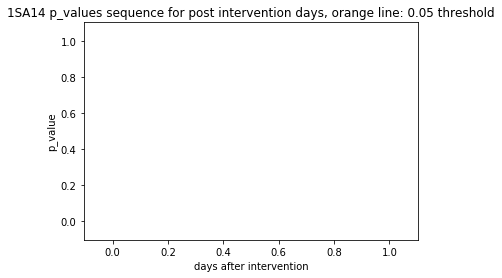

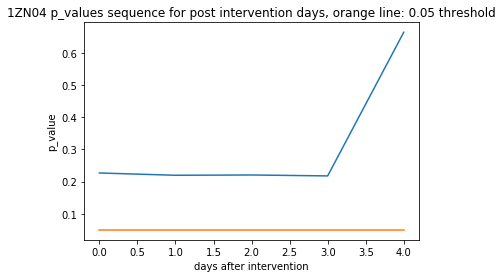

In [87]:
affichage_results_intra(p_vals_par_patient_matin_VAS_L)

# Analyse intra-sujet matin VAS_I

Combined p_value for day 0
0.0028825989464497334
Combined p_value for day 1
0.011419931015643552
Combined p_value for day 2
0.11734320687082074
Combined p_value for day 3
0.020703432999865972
Combined p_value for day 4
0.004117925183871244
Combined p_value for day 5
0.4630440771838768
Combined p_value for day 6
0.12337780572180033
affichage sequence combined p_values :


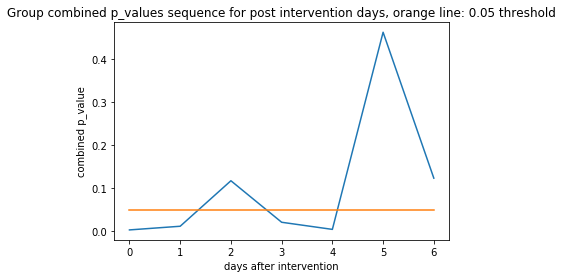

In [88]:
affichage_results_group(p_vals_par_jour_matin_VAS_I)

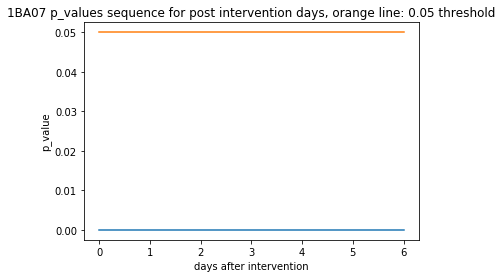

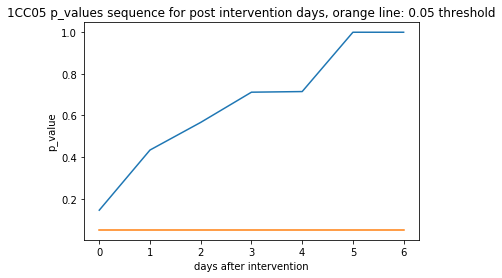

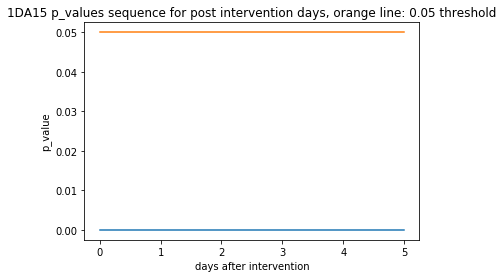

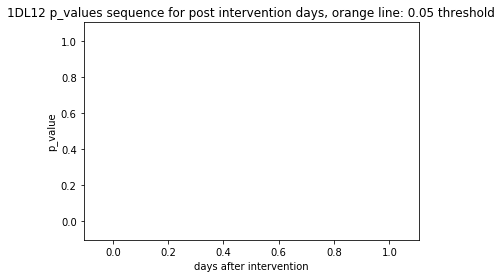

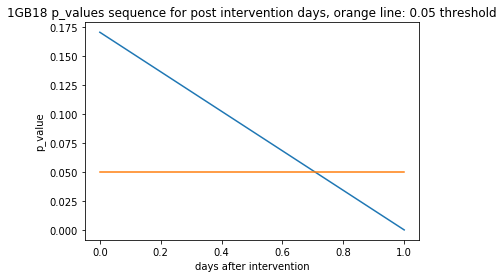

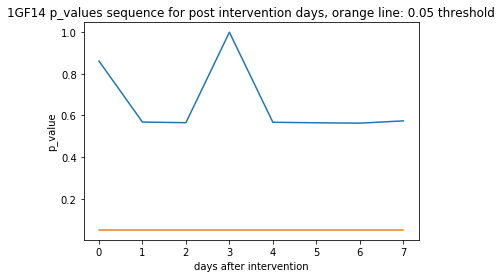

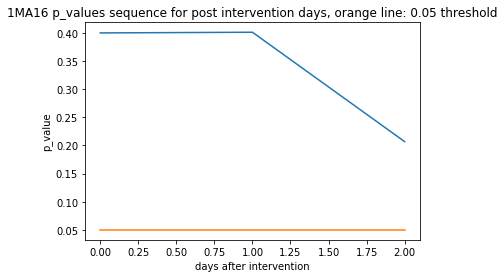

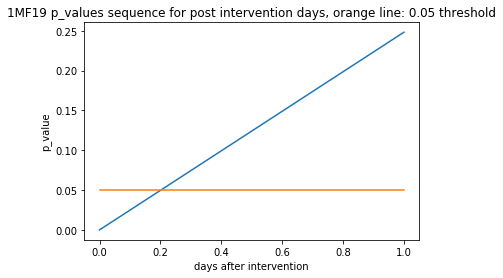

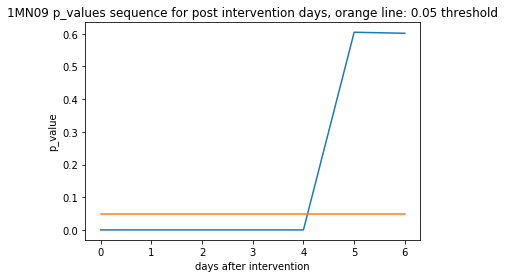

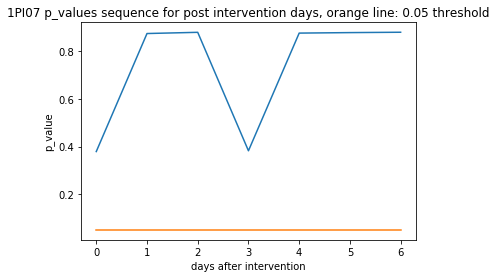

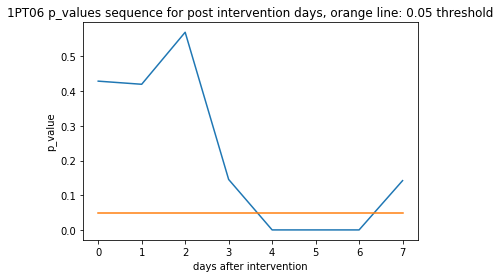

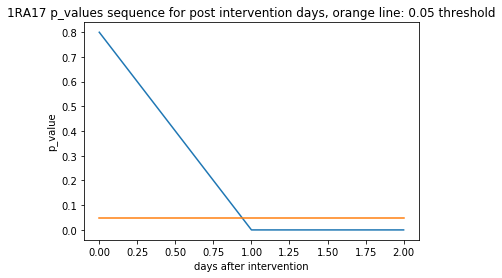

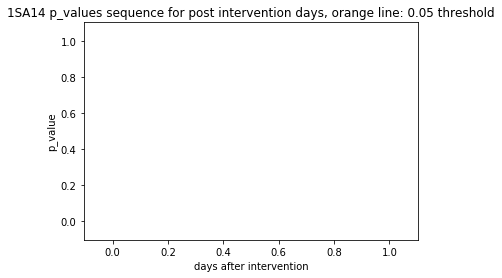

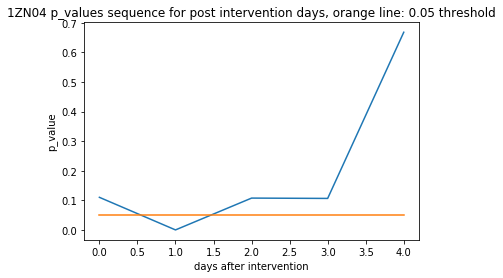

In [89]:
affichage_results_intra(p_vals_par_patient_matin_VAS_I)